True
epoch 1
Training Loss: 0.3192 Acc: 0.9067
Validation Loss: 0.1425 Acc: 0.9569
epoch 2
Training Loss: 0.1176 Acc: 0.9642
Validation Loss: 0.0907 Acc: 0.9714
epoch 3
Training Loss: 0.0808 Acc: 0.9749
Validation Loss: 0.0861 Acc: 0.9743
epoch 4
Training Loss: 0.0625 Acc: 0.9802
Validation Loss: 0.0793 Acc: 0.9725
epoch 5
Training Loss: 0.0483 Acc: 0.9844
Validation Loss: 0.0720 Acc: 0.9786
epoch 6
Training Loss: 0.0429 Acc: 0.9855
Validation Loss: 0.0726 Acc: 0.9774
epoch 7
Training Loss: 0.0348 Acc: 0.9884
Validation Loss: 0.0680 Acc: 0.9786
epoch 8
Training Loss: 0.0324 Acc: 0.9891
Validation Loss: 0.0652 Acc: 0.9812
epoch 9
Training Loss: 0.0280 Acc: 0.9909
Validation Loss: 0.0925 Acc: 0.9783
epoch 10
Training Loss: 0.0259 Acc: 0.9911
Validation Loss: 0.0734 Acc: 0.9812
Best val Acc: 0.981203


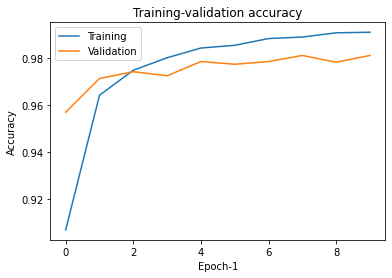

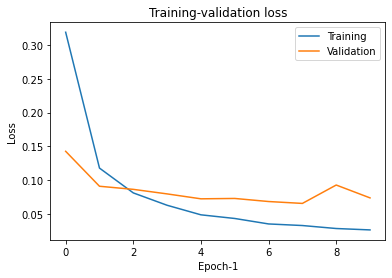

In [104]:
import copy
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transf
import torchvision.datasets as sets
import os
import PIL as pil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = None
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


# Saved as npy files earlier to reduce loading time while figuring out how to use new libraries.
np.random.seed(42)
# images = np.load("MNIST/handwritten_digits_images.npy")
# images = np.reshape(images, (len(images),28,28))
# labels = np.load("MNIST/handwritten_digits_labels.npy")



def make_dirs():
    for j in range(3):

        fold = ["train","val","test"]
        os.mkdir("MNIST/"+fold[j])
        for i in range(10):
            os.mkdir("MNIST/"+fold[j]+"/"+str(i))
# make_dirs()



# x_train_val, x_test, y_train_val, y_test = train_test_split(images, labels, random_state=42, shuffle=True, test_size=0.05)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=42, shuffle=True, test_size=0.052)

def save_images(set, y_set, dir):
    for i in range(len(set)):
        img = pil.Image.fromarray(set[i])
        path = "MNIST/" +dir+ "/" + str(int(y_set[i])) +"/"+ str(i) + ".png"
        img = img.convert("L")
        transf.Pad(2)
        img.save(path)



# save_images(x_train, y_train, "train")
# save_images(x_val, y_val, "val")
# save_images(x_test, y_test, "test")

preprocesing = transf.Compose([
    transf.Grayscale(1),
    transf.Pad(2),
    transf.ToTensor()
])


def load_images(dir):
    data = sets.ImageFolder(dir, transform=preprocesing)
    return data

train = load_images("MNIST/train")
train_size = len(train.imgs)
val = load_images("MNIST/val")
val_size = len(val.imgs)
test = load_images("MNIST/test")
test_size = len(test.imgs)
train = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
val = torch.utils.data.DataLoader(val, batch_size=1)



model = nn.Sequential(
    nn.Linear(1024,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32, 10),
)
model.to(device)


#Parameters found using a random gridsearch from an earlier assignment on MNIST
model2 = nn.Sequential(
    nn.Linear(32*32, 750),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(750, 350),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(350,10),
)
model.to(device)


adam = torch.optim.Adam(model.parameters())
adam2 = torch.optim.Adam(model2.parameters())
cross_entropy = nn.CrossEntropyLoss()



def train_model(model, loss_f, optimizer, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_model_acc = 0.0
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        print("epoch",epoch+1)
        running_loss = 0.0
        running_corrects = 0
        torch.set_grad_enabled(True)
        best_acc = 0
        for batch_idx, batch in enumerate(train):

            model.train()
            inputs, labels = batch
            inputs = inputs.view(inputs.size(0), -1)
            inputs.to(device)
            labels.to(device)

            #Forward
            out = model(inputs)
            _, preds = torch.max(out, 1)

            #Compute objective function
            loss = loss_f(out, labels)

            #Clean the gradients
            model.zero_grad()

            #Accumulate partial deriviates wrt parameters
            loss.backward()

            #Step in the opposite direction og the gradient wrt optimizer
            optimizer.step()




            #stats
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss[epoch] = running_loss / train_size
        train_acc[epoch] = running_corrects.double() / train_size
        print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_loss[epoch], train_acc[epoch]))
        running_loss = 0.0
        running_corrects = 0
        torch.set_grad_enabled(False)
        for batch_idx, batch in enumerate(val):
            model.eval()
            inputs, labels = batch
            inputs = inputs.view(1, -1)

            #Move to gpu if availible
            inputs.to(device)
            labels.to(device)

            #Forward
            out = model(inputs)
            _, preds = torch.max(out,1)

            #Compute objective function
            loss = loss_f(out, labels)


            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)



        val_loss[epoch] = running_loss / val_size
        val_acc[epoch] = running_corrects.double() / val_size

        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss[epoch], val_acc[epoch]))

        # deep copy the model
        if (val_acc[epoch] > best_acc):
            best_acc = val_acc[epoch]
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    for batch_idx, batch in enumerate(test):
        model.eval()
        inputs, labels = batch
        inputs = inputs.view(1, -1)

        #Move to gpu if availible
        inputs.to(device)
        labels.to(device)

        #Forward
        out = model(inputs)
        _, preds = torch.max(out,1)

        #Compute objective function
        loss = loss_f(out, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / test_size
    test_acc = running_corrects.double() / test_size

    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))

    print('Best val Acc: {:4f}'.format(best_acc))
    return model, train_acc, train_loss, val_acc, val_loss




model, train_acc, train_loss, val_acc, val_loss = train_model(model2, cross_entropy, adam2, 10)

#Plotting the data
fig, ax = plt.subplots()
ax.plot(train_acc, label="Training")
ax.plot(val_acc, label="Validation")
ax.set_xticklabels(np.arrange(len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training-validation accuracy")
plt.legend()
plt.show()


fig, ax = plt.subplots()
ax.plot(train_loss, label="Training")
ax.plot(val_loss, label="Validation")
ax.set_xticklabels(np.arrange(len(train_loss)))
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.title("Training-validation loss")
plt.legend()
plt.show()
